# XGBoost Classifier
## Librerias y parametros inciales

In [68]:
import lib.main_func_p1, lib.main_func_p2, lib.main_func_p3, lib.main_func_p4
from lib.main_func_p1 import timer, path
from lib.main_func_p3 import calculate_onefp
from lib.main_func_p4 import resampling_set
from lib.main_func_p4 import plot_ROC_curve
from lib.main_func_p4 import model_clf
from lib.main_func_p4 import plot_calibration_curve
from lib.main_func_p4 import plot_probability_curve

import numpy as np
import pandas as pd

from sklearn.metrics import roc_curve, auc, classification_report

from collections import OrderedDict
from importlib import reload

#XGBoost library
import xgboost as xgb

In [69]:
#####################################
# proteina (uniprot_ID)
uniprot_id = 'P00533'
path_file = path(uniprot_id)

# Parametros
seed = 142854
fp_name = 'morgan2_c'

## Carga datos

### Load external validation dataset

In [70]:
df_valid = pd.read_pickle(f'{path_file}_dataset_valid')
X_valid, y_valid = df_valid[fp_name].tolist(), df_valid['activity'].tolist()
print(f'>>> LOAD: {uniprot_id}_dataset_valid')
decoy_samples = min(list(df_valid.activity.value_counts()))

>>> LOAD: P00533_dataset_valid


### Carga y preparación de los decoys
El archivo {uniprot_id}_all_smiles.ism contiene la lista de decoys del target.
Se carga el archivo y se convierte en un data set, por ahora solo contiene el SMILE.
Se escoge aleatoriamente una muestra con la misma cantidad de compuestos activos / inactivos (1:1:1)
Se encuentra el fingerprint de cada decoy a partir del SMILE.

In [71]:
df_decoys = pd.DataFrame(columns=['smiles'])
list_d = list()
decoys_len = int(decoy_samples)
with open(f'data/_decoys/{uniprot_id}_all_smiles.ism', 'rb') as f:
    decoys_line = f.readlines()
    for line in decoys_line[1:]: #la primera linea es header
        line = line.decode('UTF-8').split()
        list_d.append(line)
df_decoys = pd.DataFrame(list_d, columns=['smiles', 'id'])

print(f'Decoys iniciales: {df_decoys.shape}')
# OPC 1: Escoger una cantidad igual al conjunto de prueba
df_decoys = df_decoys.sample(n=decoys_len, ignore_index=True)

# OPC 2: Trabajar con un porcentaje
# df_decoys = df_decoys.sample(frac=0.9, ignore_index=True, random_state=seed)

print(f'Decoys conjunto muestra: {len(df_decoys)}')
calculate_onefp(df_decoys, fp_name)
df_decoys.drop_duplicates(subset=['smiles'], inplace=True)
df_decoys.reset_index(inplace=True, drop=True)
df_decoys = df_decoys.drop(['mol'], axis=1)
df_decoys = df_decoys.drop(['smiles'], axis=1)
df_decoys['type'] = 'decoy'
df_decoys = df_decoys[['type', fp_name]]
df_decoys.head()

Decoys iniciales: (35050, 2)
Decoys conjunto muestra: 278


,type,morgan2_c
0,decoy,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,decoy,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,decoy,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
3,decoy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
4,decoy,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## Carga modelo óptimo

In [72]:
# Instanciar el modelo
xgbc_tuned = xgb.XGBClassifier()
# Cargar el modelo
xgbc_tuned.load_model(f'./models/{uniprot_id}_model.ubj')
print(f'Parametros: \n{xgbc_tuned.get_params()}')

Parametros: 
{'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'early_stopping_rounds': 10, 'enable_categorical': False, 'eval_metric': ['error', 'auc'], 'gamma': 0.0, 'gpu_id': -1, 'grow_policy': 'depthwise', 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.5, 'max_bin': 256, 'max_cat_to_onehot': 4, 'max_delta_step': 0, 'max_depth': 11, 'max_leaves': 0, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 0, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'sampling_method': 'uniform', 'scale_pos_weight': 1.0, 'subsample': 0.9, 'tree_method': 'gpu_hist', 'validate_parameters': 1, 'verbosity': None, 'alpha': 0.2, 'lambda': 2.2}


## Construcción y verificación del modelo

In [73]:
# XGBoost model
# ya tiene por defecto el conjunto de entrenamiento
tick = timer()
xgbc_tuned, df_results_model_tuned, results_ROC_fp = model_clf(xgbc_tuned, fp_name, uniprot_id, seed=seed,
                                                               save_log=True)
tock = timer(tick)
df_results_model_tuned

Protein: P00533
Total =5129
 [0.0(3553)/1.0(1576)] - ratio=2.25
Results XGBClassifier: 
-------------------------------------
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       533
         1.0       0.98      0.96      0.97       237

    accuracy                           0.98       770
   macro avg       0.98      0.98      0.98       770
weighted avg       0.98      0.98      0.98       770



,Train,Test
Metric,,
AUC,0.996,0.997
accuracy,0.978,0.982
recall_(sens),0.963,0.962
specificity,0.985,0.991
precision,0.966,0.979
f1_score,0.978,0.982
confusion_matrix,"[[2975, 45], [50, 1289]]","[[528, 5], [9, 228]]"


### ROC curve

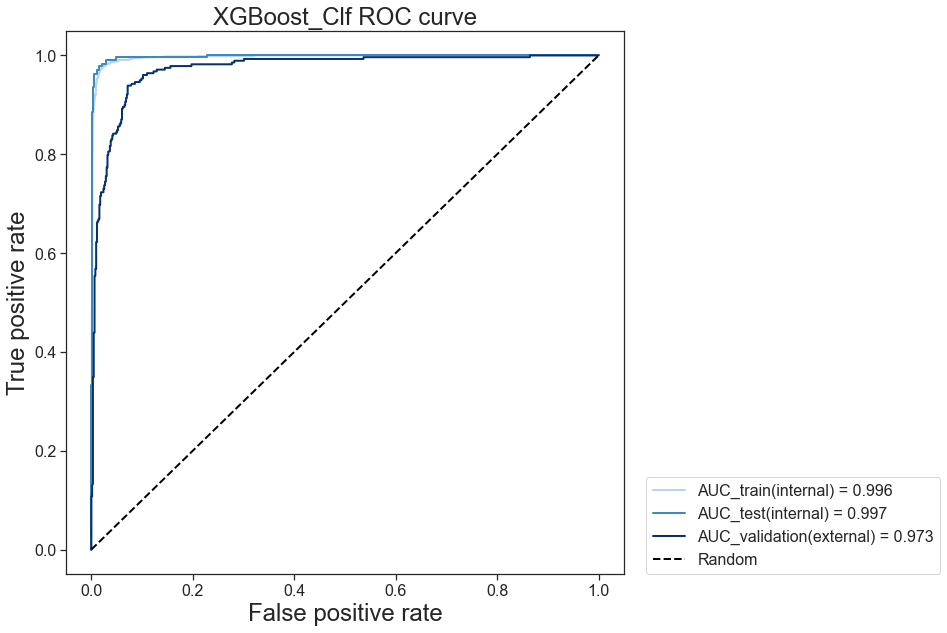

In [74]:
# Calcular probabilidades del conjunto de datos externo
pred_valid = xgbc_tuned.predict(X_valid)
df_valid['prediction'] = pred_valid

prediction_prob_valid = np.array(xgbc_tuned.predict_proba(X_valid)[:,1])
df_valid['prediction_prob'] = prediction_prob_valid

fpr_valid, tpr_valid, _ = roc_curve(y_valid, prediction_prob_valid)
auc_score_unseen = auc(fpr_valid, tpr_valid)
metrics_ROC_valid = (fpr_valid, tpr_valid, auc_score_unseen)

model_name = f'XGBoost_Clf'
metrics_ROC = results_ROC_fp.copy()
metrics_ROC.extend([metrics_ROC_valid])
metrics_ROC_name = ['train(internal)', 'test(internal)', 'validation(external)']

# print(classification_report(y_valid, pred_valid))
plot_ROC_curve(metrics_ROC, metrics_ROC_name, model_name, path_file=path_file, save_fig=True)

### Calibration curve
#### Train dataset

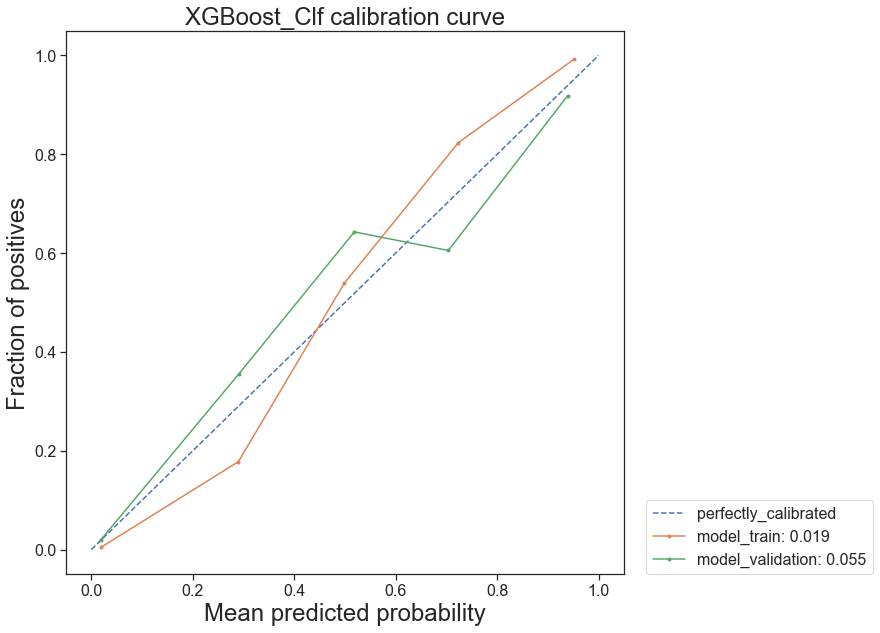

In [75]:
df_internal = pd.read_pickle(f'{path_file}_dataset_train')
X_test, y_test = df_internal[fp_name].tolist(), df_internal['activity'].tolist()
# Calcular probabilidades del conjunto de datos interno
pred_test = xgbc_tuned.predict(X_test)
df_internal['prediction'] = pred_test

prediction_prob_test = np.array(xgbc_tuned.predict_proba(X_test)[:,1])
df_internal['prediction_prob'] = prediction_prob_test

model_name = f'XGBoost_Clf'
plots_list = [df_internal, df_valid]
plots_name_list = ['model_train', 'model_validation']

plot_calibration_curve(plots_list, plots_name_list, model_name, path_file=path_file, save_fig=True)

## Uso del modelo

In [76]:
print(f'Datos iniciales: {df_valid.shape}')

# Resample
df_valid_rsmpl = resampling_set(df_valid, mode='under_sampling', ratio=1)
print('Submuestreo')

df_valid_rsmpl['type'] = 'valid_inactive'
df_valid_rsmpl.loc[df_valid_rsmpl[df_valid_rsmpl.activity == 1.0].index, 'type'] = 'valid_active'
df_valid_rsmpl.reset_index(drop=True, inplace=True)
print(df_valid_rsmpl.shape)
print(df_valid_rsmpl.activity.value_counts())

df_valid_rsmpl = df_valid_rsmpl[['type', fp_name, 'activity', 'prediction', 'prediction_prob']]

X_valid_rsmpl, y_valid_rsmpl = df_valid_rsmpl[fp_name].tolist(), df_valid_rsmpl['activity'].tolist()

df_valid_rsmpl.head()

Datos iniciales: (906, 5)
Submuestreo
(556, 6)
1.0    278
0.0    278
Name: activity, dtype: int64


,type,morgan2_c,activity,prediction,prediction_prob
0,valid_active,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,0,0.207039
1,valid_inactive,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0,0.001983
2,valid_active,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,1,0.932646
3,valid_inactive,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0,0.007773
4,valid_active,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,1,0.887400


In [77]:
df_valid_rsmpl

,type,morgan2_c,activity,prediction,prediction_prob
0,valid_active,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,0,0.207039
1,valid_inactive,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0,0.001983
2,valid_active,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,1,0.932646
3,valid_inactive,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0,0.007773
4,valid_active,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,1,0.887400
...,...,...,...,...,...
551,valid_active,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,1,0.940628
552,valid_inactive,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",0.0,0,0.187412
553,valid_inactive,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",0.0,0,0.006803
554,valid_inactive,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0,0.003477


### Predicciones

Con el modelo cargado, clasificar cada compuesto del conjunto decoys en activo: 1.0 o inactivo 0.0

In [78]:
x_decoy = df_decoys[fp_name].tolist()
pred_decoy = xgbc_tuned.predict(x_decoy)
prediction_prob = xgbc_tuned.predict_proba(x_decoy)[:,1]
prediction_prob = np.array(prediction_prob)
df_decoys['activity'] = 0.0
df_decoys['prediction'] = pred_decoy
df_decoys['prediction_prob'] = prediction_prob
df_decoys.head()

,type,morgan2_c,activity,prediction,prediction_prob
0,decoy,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0,0.000559
1,decoy,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0,0.389732
2,decoy,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",0.0,0,0.000807
3,decoy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",0.0,0,0.000259
4,decoy,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0,0.005328


In [79]:
df_decoys

,type,morgan2_c,activity,prediction,prediction_prob
0,decoy,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0,0.000559
1,decoy,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0,0.389732
2,decoy,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",0.0,0,0.000807
3,decoy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",0.0,0,0.000259
4,decoy,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0,0.005328
...,...,...,...,...,...
273,decoy,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",0.0,0,0.003222
274,decoy,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0,0.008321
275,decoy,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0,0.000429
276,decoy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0,0.002711


In [80]:
df_decoys.prediction.value_counts()

0    278
Name: prediction, dtype: int64

valid_active      278
valid_inactive    278
decoy             278
Name: type, dtype: int64


<Figure size 1080x1080 with 0 Axes>

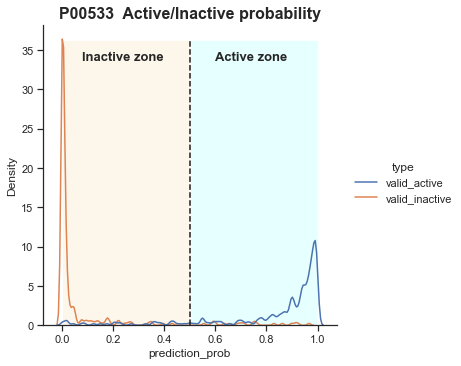

In [81]:
df = pd.concat([df_valid_rsmpl, df_decoys], ignore_index=True)
print(df.type.value_counts())

hue_order=['valid_active', 'valid_inactive']
plot_probability_curve(df, uniprot_id, hue_order=hue_order,
                       path_file=path_file, save_fig=True)

Text(0.5, 1.0, 'P00533  Active/Inactive probability')

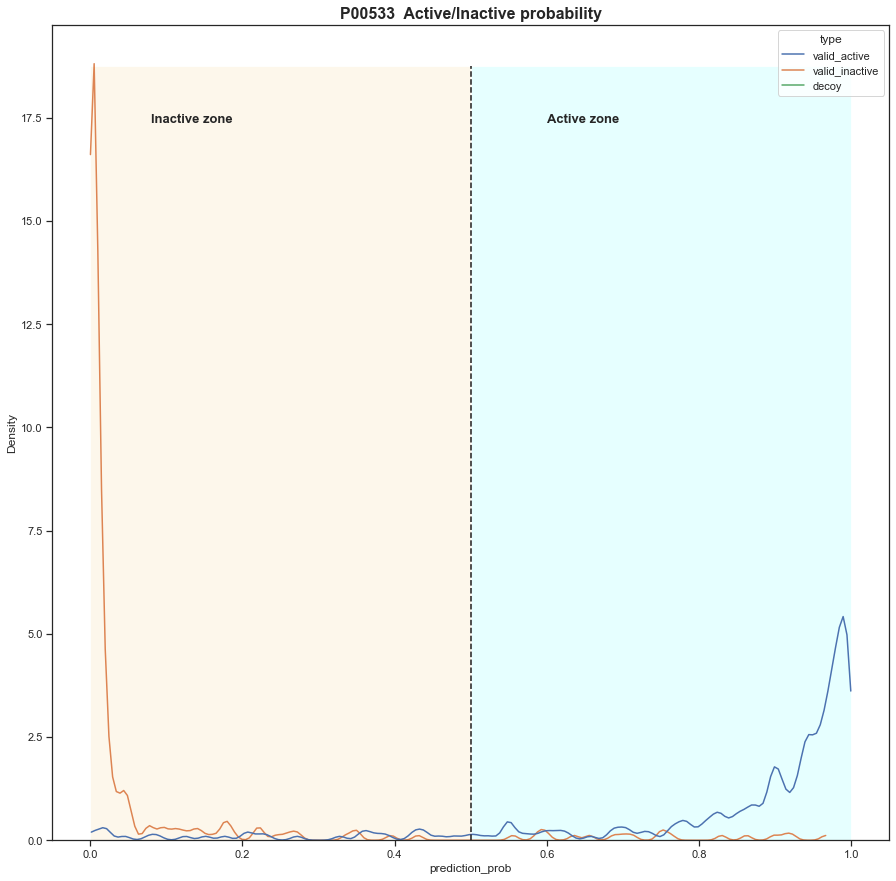

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
# hue_order=['valid_active', 'valid_inactive']
# hue_order=['valid_active', 'valid_inactive', 'decoy']
fig = plt.figure()
fig.set_size_inches(15, 15)
sns.kdeplot(data=df_valid_rsmpl, x='prediction_prob', hue="type", hue_order=hue_order, fill=False,
            bw_adjust=.1, cut=0, levels=10)
plt.axvline(x=0.5, ymax=0.95, color='k', linestyle='--')
plt.axvspan(0, 0.5, ymax=0.95, facecolor='oldlace', alpha=0.8, zorder=-100)
plt.axvspan(0.5, 1, ymax=0.95, facecolor='lightcyan', alpha=0.8, zorder=-100)
plt.text(0.08, 0.88 * plt.gca().get_ylim()[1], 'Inactive zone', fontsize=13, fontdict={"weight": "bold"})
plt.text(0.6, 0.88 * plt.gca().get_ylim()[1], 'Active zone', fontsize=13, fontdict={"weight": "bold"})
plt.title(f'{uniprot_id}  Active/Inactive probability',fontsize=16, fontdict={"weight": "bold"})

Text(0.5, 1.0, 'P00533  Active/Inactive probability')

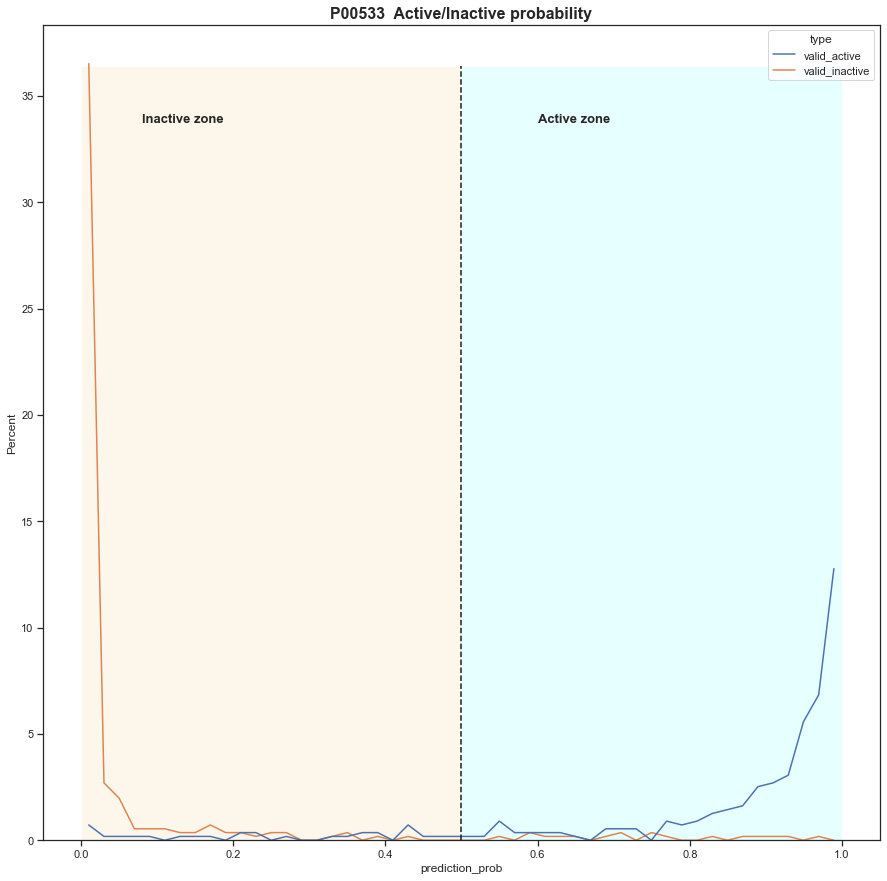

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
hue_order=['valid_active', 'valid_inactive']
fig = plt.figure()
fig.set_size_inches(15, 15)
sns.histplot(data=df_valid_rsmpl, x='prediction_prob', hue="type", hue_order=hue_order,
             bins=50, stat='percent', element="poly", fill=False)
plt.axvline(x=0.5, ymax=0.95, color='k', linestyle='--')
plt.axvspan(0, 0.5, ymax=0.95, facecolor='oldlace', alpha=0.8, zorder=-100)
plt.axvspan(0.5, 1, ymax=0.95, facecolor='lightcyan', alpha=0.8, zorder=-100)
plt.text(0.08, 0.88 * plt.gca().get_ylim()[1], 'Inactive zone', fontsize=13, fontdict={"weight": "bold"})
plt.text(0.6, 0.88 * plt.gca().get_ylim()[1], 'Active zone', fontsize=13, fontdict={"weight": "bold"})
plt.title(f'{uniprot_id}  Active/Inactive probability',fontsize=16, fontdict={"weight": "bold"})

<Figure size 1080x1080 with 0 Axes>

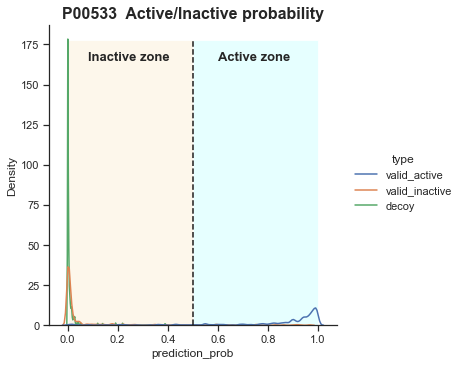

In [84]:
hue_order=['valid_active', 'valid_inactive', 'decoy']
plot_probability_curve(df, uniprot_id, hue_order=hue_order,
                       path_file=path_file, name_mod='(decoys)', save_fig=True)

In [85]:
df.to_excel('export_david.xlsx')

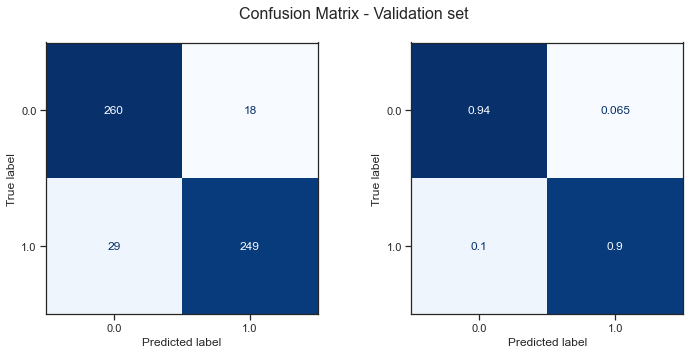

In [86]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Confusion Matrix - Validation set', size=16)
disp1 = ConfusionMatrixDisplay.from_estimator(xgbc_tuned, X_valid_rsmpl, y_valid_rsmpl,
                                              cmap=plt.cm.Blues, normalize=None,
                                              colorbar=False, ax=ax1)
disp2 = ConfusionMatrixDisplay.from_estimator(xgbc_tuned, X_valid_rsmpl, y_valid_rsmpl,
                                              cmap=plt.cm.Blues, normalize='true',
                                              colorbar=False, ax=ax2)
plt.savefig(f'{path_file}_IMG06_ConfusionMatrix.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()